In [1]:
import io
import os
import argparse
import logging
import tensorflow as tf
from PIL import Image
from waymo_open_dataset import dataset_pb2 as open_dataset

### Process a waymo tf record into a tf api tf record

In [3]:
def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def bytes_list_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))


def float_list_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [4]:
def parse_frame(frame, camera_name='FRONT'):
    """ 
    take a frame, output bbox + image
    """
    # get image
    images = frame.images
    
    for im in images:
        if open_dataset.CameraName.Name.Name(im.name) != camera_name:
            continue
        
        encoded_jpeg = im.image
        
    # get bboxes
    labels = frame.camera_labels
    for lab in labels:
        if open_dataset.CameraName.Name.Name(lab.name) != camera_name:
            continue
        annotations = lab.labels
    
    return encoded_jpeg, annotations
    

In [5]:
def create_tf_example(filename, encoded_jpeg, annotations):
    """
    convert to tensorflow object detection API format
    args:
    - filename [str]: name of the image
    - encoded_jpeg [bytes-likes]: encoded image
    - annotations [list]: bboxes and classes
    returns:
    - tf_example [tf.Example]
    """
    encoded_jpg_io = io.BytesIO(encoded_jpeg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size
    
    mapping = {1: 'vehicle', 2: 'pedestrian', 4: 'cyclist'}
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []
    filename = filename.encode('utf8')
    
    for ann in annotations:
        xmin, ymin = ann.box.center_x - 0.5 * ann.box.length, ann.box.center_y - 0.5 * ann.box.width
        xmax, ymax = ann.box.center_x + 0.5 * ann.box.length, ann.box.center_y + 0.5 * ann.box.width
        xmins.append(xmin / width)
        xmaxs.append(xmax / width)
        ymins.append(ymin / height)
        ymaxs.append(ymax / height)    
        classes.append(ann.type)
        classes_text.append(mapping[ann.type].encode('utf8'))
    
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': int64_feature(height),
        'image/width': int64_feature(width),
        'image/filename': bytes_feature(filename),
        'image/source_id': bytes_feature(filename),
        'image/encoded': bytes_feature(encoded_jpeg),
        'image/format': bytes_feature(image_format),
        'image/object/bbox/xmin': float_list_feature(xmins),
        'image/object/bbox/xmax': float_list_feature(xmaxs),
        'image/object/bbox/ymin': float_list_feature(ymins),
        'image/object/bbox/ymax': float_list_feature(ymaxs),
        'image/object/class/text': bytes_list_feature(classes_text),
        'image/object/class/label': int64_list_feature(classes),
    }))
    return tf_example

In [6]:
def process_tfr(path, output_path):
    file_name = os.path.basename(path)
    
    logging.info(f'Processing {path}')
    
    writer = tf.io.TFRecordWriter(output_path)
    dataset = tf.data.TFRecordDataset(path, compression_type='')
    for idx, data in enumerate(dataset):
        frame = open_dataset.Frame()
        frame.ParseFromString(bytearray(data.numpy()))
        encoded_jpeg, annotations = parse_frame(frame)
        filename = file_name.replace('.tfrecord', f'_{idx}.tfrecord')
        tf_example = create_tf_example(filename, encoded_jpeg, annotations)
        writer.write(tf_example.SerializeToString())
    writer.close()       

In [7]:
process_tfr('training_segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord', 
            "demo_with_camera_labels.tfrecord")

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [13]:
dataset = tf.data.TFRecordDataset('training_segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord', compression_type='')
for idx, data in enumerate(dataset):
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))

In [14]:
images = frame.images

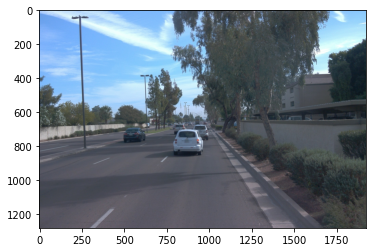

In [17]:
plt.imshow(tf.image.decode_jpeg(images[0].image), cmap=None)

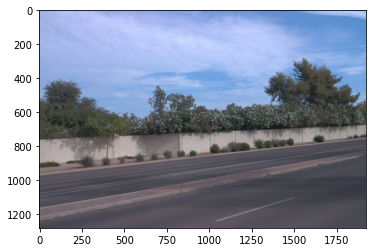

In [19]:
from PIL import Image
import io
image = Image.open(io.BytesIO(frame.images[1].image))
plt.imshow(image)